## CNN model for hard onset detection

In [18]:
# Autoload libraries
%load_ext autoreload
%autoreload 2

# Main libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import madmom
import mir_eval
from IPython.display import Audio

# Pre- and postprocessing
from modules.analysis_funcs import get_segmented_data, get_test_peaks
# Dataset handler
from datasets import Dataset
# Model
from models import FINAL_MODEL_PATH
# Visualization functions
from modules.vis import onset_visualizer, passage_extractor, slur_visualizer, piano_roll_mat
# Evaluation
from analyze_detection import evaluate

# Suppress TF logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Audio data

In [3]:
# Link to tensorflow model
MODEL_PATH = "results/cnn-training-221208/fold_0_sa_ir_strat-0.001-300eps-standard-trainable-noextend-dropout0.8_model"

# Link to audio and annotation files
# Audio should be wav
# Annotation file should contain onsets in seconds (one on each line, without headers)
audio_fname = "datasets/slurtest_add/slurtest_add_audio/slurtest05_FK.wav"
label_fname = "datasets/slurtest_add/new_annotations/slurtest05_FK.txt"

audio, sample_rate = madmom.io.audio.load_wave_file(audio_fname)
true_onsets = np.loadtxt(label_fname, usecols=0)
Audio(audio, rate=sample_rate)

/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [4]:
# Select how much of the audio to show
begin = 1 # from 
end = 5 # until

<AxesSubplot:>

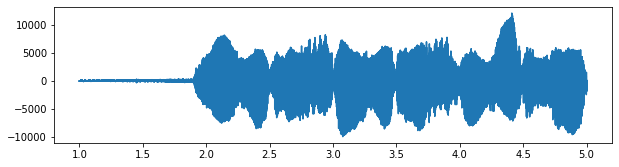

In [5]:
# Plot waveform
fig,ax = plt.subplots(figsize=(10,2.5))
passage = passage_extractor(audio,
        [ # List of onsets goes here
        ],
    [begin, end], # Segment between these seconds to plot
    sr=sample_rate
)[0]

# Function below plots only the content in the passage --- keep fixed
onset_visualizer(passage=passage, ax=ax)

### 2. Onset detection

In [6]:
# Load model - detect onsets

framerate = 0.01    # The model outputs activations with this frame rate
model = tf.keras.models.load_model(FINAL_MODEL_PATH, custom_objects = {"wbce": lambda x,y:None})
cnn_input = get_segmented_data(audio)
cnn_output = model.predict(cnn_input)
cnn_onsets = get_test_peaks(cnn_output, framerate)
print("Number of onsets detected: ", len(cnn_onsets))

Number of onsets detected:  114


In [7]:
# Evaluate the result (on the full recording)

TOL = 0.025 # seconds of tolerance window
metrics = mir_eval.onset.evaluate(true_onsets, cnn_onsets, window=TOL)
print("F-measure: ", metrics["F-measure"])
print("Precision: ", metrics["Precision"])
print("Recall: ", metrics["Recall"])

F-measure:  0.8899521531100479
Precision:  0.8157894736842105
Recall:  0.9789473684210527


<AxesSubplot:>

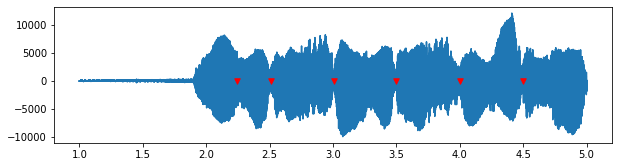

In [8]:
# Plot detections
pred_color = "red"
fig,ax = plt.subplots(figsize=(10,2.5))
passage = passage_extractor(audio,
        [ 
            cnn_onsets      # added here
        ],
    [begin,end],
    sr=sample_rate
)[0]
onset_visualizer(passage=passage, ax=ax, onset_styles={"m":["v"], "c":[pred_color]})

<AxesSubplot:>

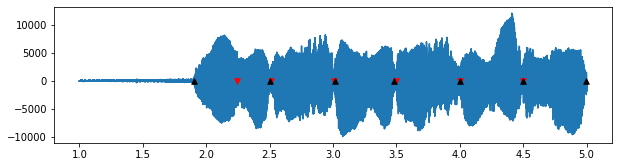

In [9]:
# Plot both detected and true onsets

true_color = "black"
fig,ax = plt.subplots(figsize=(10,2.5))
styles = {"m":["^", "v"], "c":[true_color, pred_color]}
passage = passage_extractor(audio,
        [ 
            true_onsets, 
            cnn_onsets
        ],
    [begin, end], # Segment between these seconds to plot
    sr=sample_rate
)[0]
# Function below plots only the content in the passage
onset_visualizer(passage=passage, ax=ax, onset_styles=styles)

### 3. Note data

In [10]:
# Load and show note data
notes = pd.read_csv("datasets/sc_onsets/" + os.path.basename(audio_fname)[:-4] + ".midi.csv")
notes[(notes["onset"]>begin) & (notes["offset"]<end)]

onset  offset  pitch note  octave
0   1.920   2.234     71    B       5
1   2.269   2.524     66   F#       5
2   2.524   3.093     55    G       4
3   2.524   2.768     67    G       5
4   2.768   3.023     66   F#       5
5   3.023   3.290     71    B       5
6   3.279   3.476     66   F#       5
7   3.499   3.964     55    G       4
8   3.755   3.940     66   F#       5
9   4.010   4.254     73   C#       6
10  4.254   4.509     67    G       5
11  4.509   4.730     57    A       4
12  4.718   4.985     67    G       5

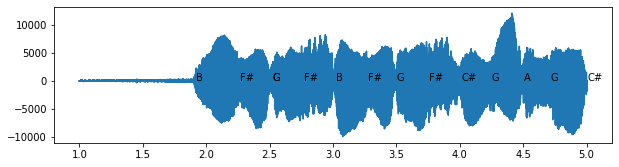

In [13]:
# Show notes in audio
fig,ax = plt.subplots(figsize=(10,2.5))
passage = passage_extractor(audio,
        [ # List of onsets goes here
        ],
    [begin, end], # Segment between these seconds to plot
    sr=sample_rate
)[0]

# Function below plots only the content in the passage --- keep fixed
onset_visualizer(passage=passage, ax=ax)

for note in notes.iloc:
    ax.annotate(text=note["note"], xy=(note["onset"],0))

Text(0, 0.5, 'MIDI number')

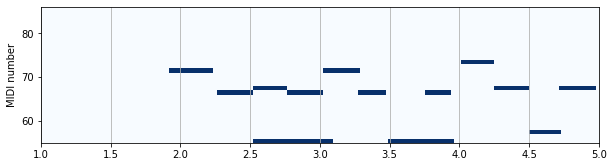

In [37]:
# Visualize as piano roll
FPS = int(1/framerate)
pr, classified_pr, onset_wins = piano_roll_mat(
    notes, 
    cnn_onsets[(cnn_onsets<end) & (cnn_onsets>begin)], 
    fps=int(1/framerate), slur_tol=0.025
)

fig,ax = plt.subplots(figsize=(10,2.5))
ax.grid(axis='x')
ax.imshow(
    pr[begin*FPS:end*FPS, notes["pitch"].min():notes["pitch"].max()].transpose(),
    extent=(begin, end, notes["pitch"].min(),notes["pitch"].max()),
    aspect="auto", origin="lower", interpolation="None", cmap="Blues"
)
ax.set_ylabel("MIDI number")


In [4]:
from music21 import *


abcScore = converter.parse("test.abc")

SubConverterFileIOException: /usr/lib/x86_64-linux-gnu/libjack.so.0
/usr/lib/x86_64-linux-gnu/libnss3.so
This application failed to start because it could not find or load the Qt platform plugin "offscreen"
in "".

Available platform plugins are: xcb.

Reinstalling the application may fix this problem.
/tmp/.mount_mscoreWGStOO/AppRun: line 26: 1434118 Aborted                 (core dumped) "${APPDIR}/bin/mscore-portable" "$@"


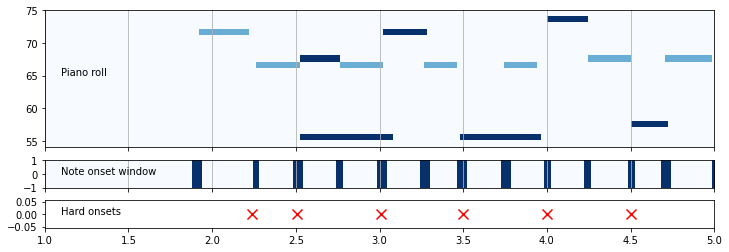

In [17]:
ymin = np.where(pr==True)[1].min()-1
ymax = np.where(pr==True)[1].max()+1
fig, axs = plt.subplots(3,1,figsize=(12,4), sharex=True, gridspec_kw={'height_ratios': [5, 1, 1]})
axs[0].text(x=1.1,y=65, s="Piano roll")
axs[0].grid(axis='x')
axs[0].imshow(
    c[begin*FPS:end*FPS, ymin:ymax].transpose(), 
    extent=(begin, end, ymin, ymax),
    aspect='auto', 
    origin="lower", 
    interpolation='none', 
    cmap='Blues'
)
axs[1].text(x=1.1,y=0.0, s="Note onset window")
axs[1].grid(axis='x')
axs[1].imshow(
    onset_matrix[begin*FPS:end*FPS, :].transpose(), 
    extent=(begin, end, -1, 1),
    aspect='auto', 
    origin="lower", 
    interpolation='none',
    cmap='Blues'
)
axs[2].text(x=1.1,y=0.0, s="Hard onsets")
axs[2].scatter(
    vis_onsets, 
    np.zeros(len(vis_onsets)),
    marker="x",
    s=100,
    c="r"
)

In [32]:
# Make corresponding changes in the musicXML file (contains the score)


array([0])